# Introduction

Atlanta, my hometown, is a highly diverse city with poorly-defined neighborhoods. While the neighborhoods are often defined by road boundaries, they are characterized by a number of other factors. In this project, I will use data from Four Square to examine the fluctuating popularity of restaurants of various kinds and use that information to classify locations into neighborhoods. I will then compare that data with google-assigned neighborhoods and determine if the two classifications are similar. 

There are a number of possible uses for this neighborhood clustering information, from consumers who would like to know where to go for a particular cuisine, to developers looking to fit a new restaurant into the neighborhood. Additionally, this information could be used by city planning officials in the permitting process.

# Data

This project will utilize data from 2 sources:
1. Trending venue data from Foursquare. This will be pulled between 6-7 PM on a Friday (peak restaurant selection time) and saved to a file, since repeated calls to the Foursquare API would result in different trending information. An extension of this project could be to examine the fluctuation of neighborhood boundaries over the course of a week, but that is beyond the scope of this project. 
2. Neighborhood Planning Unit data from The City of Atlanta's GIS database. Accessed through this URL: https://dcp-coaplangis.opendata.arcgis.com/datasets/npu/geoservice The city provides an API to interact with the GIS data, which I will use to extract the geometric boundaries of each neighborhood. The output of this call contains the following information: 
     
     "attributes": {
            "OBJECTID": 260,
            "LOCALID": null,
            "NAME": "K",
            "GEOTYPE": "NPU",
            "FULLFIPS": null,
            "LEGALAREA": null,
            "ACRES": 1528.29,
            "SQMILES": 2.39,
            "OLDNAME": null,
            "NPU": null
         },
         "geometry": {
            "rings": [
               [
                  [
                     -84.4173772073577,
                     33.772197013770004
                  ],
                  
The "Name" attribute is the neighborhood planning unit name, a proxy for a traditional neighborhood name like "midtown". The geometry information will be used to build a boundary box, and each trending restaurant will be placed within those boundaries and classified. 

# Initializations

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
import requests
from pandas.io.json import json_normalize
from sklearn.model_selection import ParameterGrid
import math
from IPython.display import HTML, display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# Methodology
## Connecting with the City of Atlanta's GIS system
### Exploring GIS results
The GIS system includes both the neighborhood planning unit (NPU) name, and coordinates for its boundaries. In this section, we will plot these boundaries as an initial exploration. The URL below was created using the City of Atlanta GIS API Explorer system listed in Section 2.

In [2]:
url = 'https://gis.atlantaga.gov/dpcd/rest/services/OpenDataService/FeatureServer/4/query?where=1%3D1&outFields=NAME&outSR=4326&f=json'

We will process the json file into a readable dataframe.

In [3]:
results = requests.get(url).json()
dataframe = json_normalize(results)
data = dataframe['features'][0]
cleandata = json_normalize(data)
cleandata.head()

,attributes.NAME,geometry.rings
0,T,"[[[-84.41391130598113, 33.75469930680354], [-8..."
1,F,"[[[-84.34858126240417, 33.817302459207255], [-..."
2,C,"[[[-84.4175773783347, 33.83996741007558], [-84..."
3,Q,"[[[-84.52963298537476, 33.733439488935424], [-..."
4,Y,"[[[-84.36846557192858, 33.72467524195221], [-8..."


In order to visualize the structure of the official neighborhoods listed in the city's documentation, we will plot their borders using folium and the geometry in the above dataframe.

In [4]:
npu_map = folium.Map(tiles='Stamen Toner',location=[33.755845, -84.38902], zoom_start=10)

for index, row in cleandata.iterrows():
    coord = row['geometry.rings'][0][:]
    for ll in coord:
        lat = ll[1]
        long = ll[0]
        folium.Circle(
            [lat, long],
            radius=3,
            fill=True
            ).add_to(npu_map)

npu_map.save('neighborhoods.html')
# display(npu_map)

Due to the number of points plotted above, folium has trouble rendering maps in jupyter. The resulting map can be found at https://github.com/kmfullerton/Coursera_Capstone/blob/master/neighborhoods.html

### Create GIS information dataframe
GIS systems provide extensive data, and can be used for a variety of geo-spatial calculations. However, most of these calculations are beyond the scope of this project. Consequently, the GIS data here will be used to classify venues into neighborhoods based on the closest boundary point via euclidian distance. While this is not a rigorous methodology, additional computations in the GIS system are complex and would require a great deal of work that is not focused on data science. In this project, we will assume that a venue is in the NPU where it lies closest to a boundary point.

This dataframe will contain the coordinates of each boundary point and the NPU name that is assigned to that boundary point.

In [5]:
gis_df = pd.DataFrame(columns=['NPU', 'Latitude','Longitude'])
for index, row in cleandata.iterrows():
    coord = row['geometry.rings'][0][:]
    name = row['attributes.NAME'][0][:]
    for ll in coord:
        lat = ll[1]
        long = ll[0]
        gis_df = gis_df.append({"NPU": name,"Latitude":lat,"Longitude": long}, ignore_index=True)
        
gis_df.head()

,NPU,Latitude,Longitude
0,T,33.754699,-84.413911
1,T,33.754696,-84.413739
2,T,33.754697,-84.413553
3,T,33.754698,-84.413455
4,T,33.754701,-84.412775


## Connect with Foursquare

In this hidden cell, the authorization criteria are provided for interacting with the Foursquare API.

In [6]:
# @hidden_cell
client_secret = 'PLV5C4EDNBSRH4AMBKOXNGHFZWHEWCGULGTQLPQZVQFJFYZO'
client_id = 'HE3V0C15YMFATHFBWRAZ0B32H12HYYSJ1HJ523U02CKPEO3M'

### Create latitude/longitude grid to collect data all over Atlanta
Since the number of API calls and results are limited, we will generate a search grid that overlays the Atlanta area and submit the API call at each node on the grid. The width and height of the space between nodes is approximately 4500 meters, so the radius for the API call will be set to that value. Note that the boundaries of the city are poorly defined and non-orthogonal, so a linear approximation is used.

#### Define functions used in this section and set visable API parameters

In [7]:
# Define a function to make the search ranges
def make_range(minval, maxval, steps):
    step = (maxval - minval)/steps
    val = minval
    outlist = list()
    outlist.append(minval)
    while val <= maxval:
        val += step
        outlist.append(val)
    return outlist

#### Build search grid
The City of Atlanta is poorly defined, and the NPU's are skewed to the southwest side of the city. Consequently, we will analyze only points within the NPU area. We will set the minimum and maximum latitude and longitude for our search grid by finding those same values within the GIS dataframe.

In [8]:
min_lat = gis_df['Latitude'].min()
max_lat = gis_df['Latitude'].max()
min_long = gis_df['Longitude'].min()
max_long = gis_df['Longitude'].max()

In [9]:
# Create the lists for latitude and longitude
lat_list = make_range(min_lat, max_lat, 10)
long_list = make_range(min_long, max_long, 10)

# Generate the search grid
grid = {'latitude':lat_list, 'longitude':long_list}
grid = ParameterGrid(grid)

#### Visualize search grid

In [10]:
grid_map = folium.Map(tiles='Stamen Toner',location=[33.755845, -84.38902], zoom_start=10)

for set in grid:
    lat = set['latitude']
    long = set['longitude']
    folium.Circle(
        [lat, long],
        radius=8,
        fill=True,
        color='green'
        ).add_to(grid_map)
grid_map.save('GridMap.html')
grid_map

### Iterate through grid search and call API
With each API call, the json object must be converted into a dataframe, and that data will be appended to a larger analysis frame.
Note that each call will not have the same number of output columns. In testing, it was determined that the most frequently missing column is the neighborhood value. When present, this will be collected. When not present, it will be skipped. Data points with an assigned neighborhood value will be used for validation of the clustering model.

#### Set API parameters and define useful functions

In [11]:
# Set the API parameters that are non-user identifying
radius = 4000
limit=50
ver = '20180604'

In [12]:
# Define a function to extract the venue category information from the json results
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Perform grid search and store data

In [13]:
# Generate an empty dataframe to contain all results
fsq_df = pd.DataFrame(columns=['name', 'categories', 'latitude', 'longitude', 'neighborhood'])

# Iterate over the search grid
for set in grid:
    # Extract latitude and longitude values
    lat = set['latitude']
    long = set['longitude']
    
    # Build API URL
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&limit={}&radius={}'.format(client_id, client_secret, lat, long, ver, limit,radius)
    
    # API call
    results = requests.get(url).json()
    
    # Extract useful data from json
    items = results['response']['groups'][0]['items']
    dataframe = json_normalize(items)
    
    # Create mini working dataframe to contain only the columns of interest
    data = pd.DataFrame()
    data['name'] = dataframe['venue.name']
    data['categories'] = dataframe['venue.categories']
    
    # Apply the get categories function to further strip structure in that field
    data['categories'] = data.apply(get_category_type, axis=1)
    data['latitude'] = dataframe['venue.location.lat']
    data['longitude'] = dataframe['venue.location.lng']
    
    # Check to see if neighborhood data is present, and store it is so
    if 'venue.location.neighborhood' in list(dataframe.columns.values):
        data['neighborhood'] = dataframe['venue.location.neighborhood']
    else: 
        data['neighborhood'] = np.nan
        
    # Append the mini working dataframe to the results dataframe
    fsq_df = pd.concat([fsq_df, data])
    
# Check shape and columns of results dataframe    
print('Size of dataframe: ', fsq_df.shape)
fsq_df.head()

Size of dataframe:  (5901, 5)


,name,categories,latitude,longitude,neighborhood
0,Zen Massage,Massage Studio,33.666481,-84.549732,NaN
1,Tom Lowe Trap & Skeet Range,Gun Range,33.671201,-84.564226,NaN
2,Camp Creek World of Beverages,Liquor Store,33.657393,-84.511874,NaN
3,Piece of Cake,Bakery,33.656218,-84.513946,NaN
4,Wolf Creek Amphitheater,Theater,33.674711,-84.567392,NaN


Because this search is conducted in circles around points on a square grid, there may be duplicate entries. We will delete these duplicates to simplify analysis.

In [14]:
fsq_df.drop_duplicates(inplace=True)
print('Reduced size of dataframe: ',fsq_df.shape)

Reduced size of dataframe:  (2153, 5)


## Classify each venue into a neighborhood planning unit
In order to create this designation, we will use our Euclidean distance function from above. For each venue point, the Euclidean distance from all of the NPU boundary points. The distance vector will be sorted, and the venue will be classified inot an NPU based on the shortest distance. 

As a first step, we will add an empty column to the fsq_df dataframe in which to store the NPU classification and reset the index.

In [15]:
fsq_df['NPU'] = ''
fsq_df.reset_index(inplace=True)

We will iterate over the four square dataframe, calculate the distance from the venue to each boundary point, and select the NPU name of the closest boundary point for each venue.

In [16]:
for index1, row in fsq_df.iterrows():
    # Select the coordinates of each venue
    venue_coord = [row['latitude'], row['longitude']]
    name = row['name']
    # Create a dataframe in which to store the distance information for this venue
    dist_frame = gis_df
    
    # Calculate the Euclidean distances from each boundary point to the venue coordinates
    dist_frame['x dist'] = np.abs(venue_coord[0] - dist_frame['Latitude'])
    dist_frame['y dist'] = np.abs(venue_coord[1] - dist_frame['Longitude'])
    dist_frame['Distance'] = np.sqrt((dist_frame['x dist'] ** 2) + (dist_frame['y dist']**2))
    
    # Find the NPU at the minimum distance
    mindex = dist_frame['Distance'].idxmin()
    closest_npu = dist_frame.iloc[mindex][0]

    # Store this NPU data in the fsq_df dataframe
    fsq_df.at[index1,'NPU'] = closest_npu
    
    # Print to monitor progress
    print('Venue Name: {}, NPU: {}           '.format(name, closest_npu), end='\r')
    
fsq_df.to_csv('Foursquare Processed Data.csv')
print('\n All venues classified.')

Venue Name: Kung Fu Tea 功夫茶, NPU: B                             NPU: B                             
 All venues classified.


In [17]:
# Check to make sure all the NPU's are represented.
fsq_df['NPU'].unique()

array(['P', 'R', 'X', 'Z', 'O', 'S', 'Y', 'W', 'Q', 'H', 'I', 'T', 'V',
       'K', 'N', 'G', 'L', 'E', 'D', 'F', 'C', 'B', 'A'], dtype=object)

## Exploratory Data Analysis
Much of the EDA necessary for this analysis is performed in the maps plotted above. However, will will perform an abbrieviated analysis here.

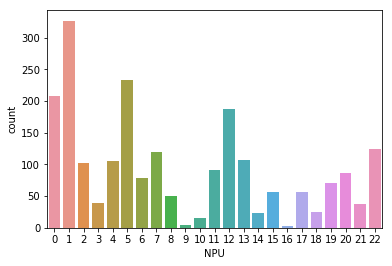

In [48]:
# Plot the number of venues per NPU
counts = sns.countplot(x='NPU', data=fsq_df)
fig = counts.get_figure()
fig.savefig('NPUcounts') 

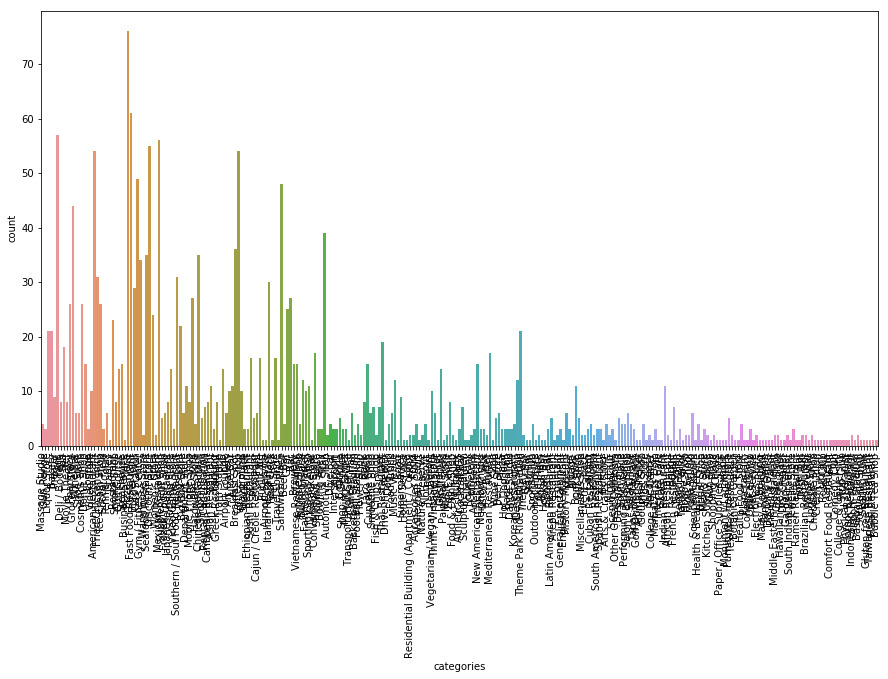

In [59]:
# Plot the number of venues per type
plt.figure(figsize=(15,8))
cat_types = sns.countplot(x='categories', data=fsq_df)
cat_types.set_xticklabels(cat_types.get_xticklabels(),rotation=90)
fig = cat_types.get_figure()
fig.savefig('catcounts')

As can be clearly seen above, there are a number of categories from Foursquare that have a single location. This suggests that this categorization is unlikely to provide useful information. 


# Clustering Analysis
## Visualize Raw Data

In [20]:
venues_map = folium.Map(tiles='Stamen Toner',location=[lat, long], zoom_start=11)

for index, row in fsq_df.iterrows():
    lat = row['latitude']
    long = row['longitude']
    label = row['name']
    category = row['categories']
    
    folium.Circle(
        [lat, long],
        popup=label,
        radius=10,
        fill=True
        ).add_to(venues_map)

venues_map.save('Venues.html')
# display(venues_map)

Due to the number of points plotted above, folium has trouble rendering maps in jupyter. The resulting map can be found at https://github.com/kmfullerton/Coursera_Capstone/blob/master/Venues.html

## Perform clustering analysis on restaurant data

### Convert neighborhood strings into dummy variables
We will use the label encoder function from SKlearn to create an integer representing each given neighborhood.

In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = fsq_df['NPU'].to_list()
neighborhood_labels = le.fit_transform(y)
fsq_df['NPU'] = neighborhood_labels
fsq_df.head()

,index,name,categories,latitude,longitude,neighborhood,NPU
0,0,Zen Massage,Massage Studio,33.666481,-84.549732,NaN,13
1,1,Tom Lowe Trap & Skeet Range,Gun Range,33.671201,-84.564226,NaN,13
2,2,Camp Creek World of Beverages,Liquor Store,33.657393,-84.511874,NaN,13
3,3,Piece of Cake,Bakery,33.656218,-84.513946,NaN,13
4,4,Wolf Creek Amphitheater,Theater,33.674711,-84.567392,NaN,13


### Split dataframe into X and y arrays

In [22]:
X = fsq_df.drop(axis=1, columns=['index', 'name', 'categories', 'neighborhood', 'NPU'])
X = np.array(X)

y = fsq_df.drop(axis=1, columns=['index', 'name', 'categories', 'neighborhood', 'latitude', 'longitude'])
y = np.array(y)
y = np.reshape(y, -1)

# Check that sizes are compatible
print(X.shape)
print(y.shape)

(2153, 2)
(2153,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Cross Validation Tuning

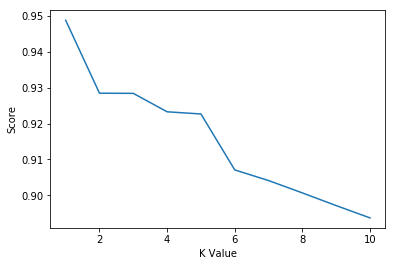

In [35]:

neighbors = list(range(1,11,1))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())
    
plt.plot(neighbors, cv_scores)
plt.xlabel('K Value')
plt.ylabel('Score')
# plt.show()
plt.savefig('kvalues')

### Perform K Nearest Neighbors Classification with the optimal number of clusters.
We will use the graph above to select the best k value

In [25]:
k = 4
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

## Compare results of analysis to City of Atlanta Neighborhood data
### Using the sklearn score function

In [26]:
print(knn.score(X_test,y_test, pred))

0.9409202286958889


### Visually comparing results
In this map, each venue in the test set is mapped. The color of the point indicates whether or not the K Nearest Neighbors classification matched the NPU classification; green indicates a match, while red indicates a mismatch. 

In [34]:
pred_map = folium.Map(tiles='Stamen Toner',location=[lat, long], zoom_start=10)

for index in range(0, X_test.shape[0], 1):
    lat = X_test[index][0]
    long = X_test[index][1]
    y_true = y_test[index]
    y_pred = pred[index]
    if (y_true == y_pred):
        color = 'green'
    else:
        color = 'red'
            
    folium.Circle(
        [lat, long],
        popup=label,
        radius=15,
        color=color,
        fill=True
        ).add_to(pred_map)

pred_map.save('predictions.html')
pred_map

### Discussion of Results
Based on the score produced by sklearn, it seems that the KNN classifier does a decent job of predicting the neighborhood for a given venue. When viewed on a map, it becomes apparent that there is a systemic bias to the data. Misclassifications are overwhelmingly focused in the south-west portion of the city, while the north and east portion of the city are almost entirely correctly classified. 
This skew is likely due to two issues:
1. Population density is higher in the north and east portions of the city, and lower in the southwest. This could result in a lower number of venues reported to Foursquare in that region, and thus an underlying bias in the dataset.
2. Due to lower population density, the NPU's in the southwest corner of the city are larger. This means that a point lies near the edge of an NPU may be classified in a different neighborhood by the nearest neighbors classifier. This error is a function of the way we classified venues into NPU's. We used an approximation to determine which boundary each venue was closest to in the classification, while the KNN algorithm considers irregular boundaries. This could be mitigated in  2 ways:

    1. Modify the NPU classification method. With additional time and resources, the GIS data could be used to create more accurate determinations. However, that level of exploration was deemed beyond the scope of this work.

    2. Exclude data from Foursquare that does not have a neighborhood classification. During this exploration, it was determined that the majority of the data from Foursquare includes a field for neighborhood, but that field is NaN for the majority of the data. With expanded access to Foursquare, we could exclude all venues with an NaN neighborhood value, and then remove the NPU classification approximation. 